## Project 3: Analyzing A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#The seed is set to assure we get the same answers on quizzes as they are set up below
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query("(group == 'treatment' & landing_page == 'old_page') | (group == 'control' & landing_page == 'new_page')").count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [8]:
# Check for duplicated rows.
df.duplicated(subset=None, keep='first').sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# Drop rows where the group does not align with the correct landing_page and save remaining rows in new dataframe df2.
df2 = df.drop(df.query("(group == 'treatment' & landing_page == 'old_page') | (group == 'control' & landing_page == 'new_page')").index)

In [10]:
# Double Check all of the misaligned rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

In [12]:
# Confirm the final number of rows in new dataframe.
df.shape, df2.shape

((294478, 5), (290585, 5))

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

c. What is the row information for the repeat **user_id**? 

In [14]:
# View all information from rows with duplicated user_id
df2[df2["user_id"].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
# Drop row with duplicated user_id.
df2.drop_duplicates(["user_id"], keep="last", inplace=True)

In [16]:
# Confirm the row was dropped.
df2[df2["user_id"].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted


In [17]:
# Confirm final number of rows.
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2.query("group == 'control'")["converted"].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2.query("group == 'treatment'")["converted"].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
df2.query("landing_page == 'new_page'").count()[0]/df2.count()[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

>Since both groups exhibit a similar probability of convertion (around 12%), the data fail to indicate that the new landing page leads to a higher conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

>$H_{0}$ = Pold >= Pnew

>$H_{1}$ = Pold < Pnew

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
# Calculate p_new.
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
# Calculate p_new.
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [24]:
n_new = df2.query("landing_page == 'new_page'").count()[0]
n_new

145310

d. What is $n_{old}$?

In [25]:
n_old = df2.query("landing_page == 'old_page'").count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
new_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
(p_new - p_old)

0.0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
n_new = df2.query("landing_page == 'new_page'").count()[0]
n_old = df2.query("landing_page == 'old_page'").count()[0]
p_new = df2.query("landing_page == 'new_page'").count()[0]/df2.count()[0]
p_old = df2.query("landing_page == 'old_page'").count()[0]/df2.count()[0]

In [30]:
# Generate sampling distribution of the differences between the conversion rates of new landing page 
# and old landing page.
p_diffs = []
new_convert = np.random.binomial(n_new, p_new, 10000)/n_new
old_convert = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_convert - old_convert

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

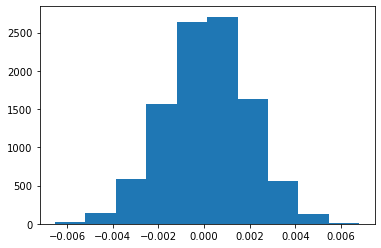

In [31]:
#Plot histogram for sampling distribution
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
obs_diff = df2.query('group == "treatment"')["converted"].mean() - df2.query('group == "control"')["converted"].mean()

In [33]:
(p_diffs > obs_diff).mean()

0.8212

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>In this case, we calculated the probability that the difference between conversion rates of the new landing page and the old landing page from the sampling distribution (p_diffs) is higher than the difference between the conversion rates of the new landing page and the old landing page in the original sample (obs_diff). In scientific studies, this is called a p-value.

>Originally, the null hypothesis stated that the old landing page led to either higher or equal conversion rate than the new landing page. The p-value tells us how probable it is that the observed difference is in the sampling distribution. Since the p-value is 0.9059 (i.e., larger than the 0.05 threshold), this means that it is very likely that our observed difference is in the distribution, and so we would fail to reject the null and would consider the conversion rate of the new landing page and the old landing page as the same. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' & converted == '1'").shape[0]
convert_new = df2.query("landing_page == 'new_page'& converted == '1'").shape[0]
n_old = df2.query("landing_page == 'old_page'").count()[0]
n_new = df2.query("landing_page == 'new_page'").count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])

z_test, pval = sm.stats.proportions_ztest(count, nobs, alternative="smaller")
z_test, pval

(1.3109241984234394, 0.9050583127590245)

In [36]:
# Confirming the significance of z-test by retrieving critical value for two-tailed test
import scipy.stats

cval = scipy.stats.norm.ppf(1-.05/2)
cval*-1, cval

(-1.959963984540054, 1.959963984540054)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>The z-score is neither lower nor higher than the negative and positive critical values, respectively, which entails the failure to reject the null. This is supported by the p-value of 0.905. As mentioned above, the null hypothesis states that the old landing page lead to either higher or equal conversion rate than the new landing page. Thus, failing to reject the null means that the conversion rate of the old landing page is either higher or equal than that of the new landing page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>A logistic regression, since it involves only two potential outcomes that are categorical.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2[["new_page", "old_page"]] = pd.get_dummies(df2["landing_page"])
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.drop(["group", "landing_page"], axis=1, inplace=True)

df2["intercept"] = 1

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
lm = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        19:44:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [40]:
# Calculate exponentiated coefficient
np.exp(-0.0150)

0.9851119396030626

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

>These results indicate that the p-value associated with ab_page is 0.190. It differs from the p-value generated in the hypothesis-testing section because the null and alternative hypothesis are different:

>In the hypothesis-testing section, the null hypothesis establishes that the new landing page leads to equal or lower conversion rate than the old landing page. In this way, we are doing a one-tailed test. On the other hand, in the regression, the null hypothesis establsihes that conversion rates of new and old landing pages are the same. Therefore, we are doing there a two-tailed test. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>Considering other potentially relevant variables in the regression model may allow for a better prediction of the dependent variable. Are there any trends within the groups labeled as "control" or "treatment"? Gender? Age? Including variables such as these may give more insight into the effect the new landing page has on the participants. 

>However, it is important to keep in mind that too many additions to the number of independent variables could reduce the accuracy of the model (Bellman R.E. Adaptive Control Processes. Princeton University Press, Princeton, NJ, 1961.), and the the risk of multicollinearity increases, as well. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
# Create countries column
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [42]:
# Find out the values in country.
df_new["country"].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [43]:
# Create the necessary dummy variables
df_new[["CA", "UK", "US"]] = pd.get_dummies(df_new["country"])
df_new.drop(["country"], axis=1, inplace=True)

In [44]:
# Run logistical regression for conversion with country ("CA" as baseline)
lm = sm.Logit(df_new["converted"], df_new[["intercept", "UK", "US"]])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Mar 2021   Pseudo R-squ.:               1.521e-05
Time:                        19:44:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [45]:
# Calculate exponentiated coefficient
np.exp(0.0507), np.exp(0.0408)

(1.052007243765014, 1.0416437559600236)

>According to the p-values in the model, neither country is a significant variable to the conversion rate. The coefficients point out the same: both the UK and the US show virtually equal coefficient, which is slightly above 1. This means that the conversion rate is as likely among participants from each of the three countries, holding all else constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
# Create interacting factors (HOT vectors):
df_new["UK_treatment"] = df_new["UK"] * df_new["ab_page"]
df_new["US_treatment"] = df_new["US"] * df_new["ab_page"]
df_new["CA_treatment"] = df_new["CA"] * df_new["ab_page"]

In [47]:
# Run logistical regression for conversion with country ("CA" as baseline) and landing_page
lm = sm.Logit(df_new["converted"], df_new[["intercept", "UK_treatment", "US_treatment"]])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Mar 2021   Pseudo R-squ.:               1.082e-05
Time:                        19:44:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3164
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9926      0.008   -252.910      0.000      -2.008      -1.977
UK_treatment     0.0112      0.018      0.626      0.532      -0.024       0.046
US_treatment    -0.0144      0.012     -1.155      0.248      -0.039       0.010
================================================================================
"""

In [48]:
# Calculate exponentiated coefficient
np.exp(0.0112), np.exp(-0.0144)

(1.011262954811771, 0.985703184122443)

>Similarly, according to the p-values in this second model, the interaction of the variables country and group is not significant to the conversion rate. The coefficients point out the same: both variables show virtually equal coefficient, which is approximately 1. This means that the conversion rate is as likely among participants from each of the three countries, holding all else constant.

# EXTRA: What about time? Is that significant for conversion?

Here we will determine whether the time of the day of the exposure to the landing page.

In [49]:
# Change timestamp data type to datetime.
df_new["timestamp"] = pd.to_datetime(df_new["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")

In [50]:
# Extract time from timestamp into another column.
df_new['time'] = df_new['timestamp'].dt.time

In [51]:
# Create a function to label time. There are four buckets: morning, afternoon, evening and night. 
# It is important to keep in mind that the buckets would be better decided taking into consideration the 
# characteristics of the industry (which I am not specialist about).
from datetime import time


def label_time(row):
    if row["time"] >= datetime.time(hour=6, minute=0, second=0, microsecond=0, tzinfo=None) and row["time"] < datetime.time(hour=12, minute=0, microsecond=0, tzinfo=None):
        time =  "morning"
    elif row["time"] >= datetime.time(hour=12, minute=0, second=0, microsecond=0, tzinfo=None) and row["time"] < datetime.time(hour=18, minute=0, microsecond=0, tzinfo=None):
        time =  "afternoon"
    elif row["time"] >= datetime.time(hour=18, minute=0, second=0, microsecond=0, tzinfo=None) and row["time"] < datetime.time(hour=23, minute=59, microsecond=59, tzinfo=None):
        time = "evening"
    else:
        time = "night"
    return time

In [52]:
# Apply the function to our data set and assign labels in an additional column called "time_label."
df_new["time_label"] = df_new.apply(label_time, axis = 1)

NameError: name 'datetime' is not defined

In [ ]:
# Confirm that columns where created correctly.
df_new.head()

In [ ]:
# Conversion rates for every time in the day
morning_conv = df_new.query("time_label == 'morning'")["converted"].mean()
afternoon_conv = df_new.query("time_label == 'afternoon'")["converted"].mean()
evening_conv = df_new.query("time_label == 'evening'")["converted"].mean()
night_conv = df_new.query("time_label == 'night'")["converted"].mean()
morning_conv, afternoon_conv, evening_conv, night_conv

In [ ]:
# Create dummy variables for the column time_label:
df_new[["afternoon", "evening", "morning", "night"]] = pd.get_dummies(df_new["time_label"])
df_new.drop(["time_label"], axis=1, inplace=True)

In [ ]:
# Run logistic regression model with variabels for times of day.
lm = sm.Logit(df_new["converted"], df_new[["intercept", "afternoon", "evening", "night"]])
results = lm.fit()
results. summary()

In [ ]:
# Calculate exponentiated coefficient
np.exp(0.0046), np.exp(0.0056), np.exp(-0.0321)

>Similarly to the models above, time of the day does not seem to have an effect on conversion: Conversion seems as likely under all time variables, except for "night," which seems to lead to a slightly lower conversion.

<a id='conclusions'></a>
## Conclusions

>Drawing from our analysis, given that the new landing page does not seem to lead to a higher conversion rate in any of the calculations above, I would not recommend to go ahead and adopt it. The remaining options are either to keep the old landing page as is, or to implement the A/B test for a longer period of time. However, it is important to keep in mind that as the sample  size gets larger, we are more likely to see significant effects - only due to sample size. Considering that the sample already has more than 200,000 participants, the best option may be to keep the old landing page and attempt changes of other kind for higher conversion.